# **Deforum Stable Diffusion v0.6**
[Stable Diffusion](https://github.com/CompVis/stable-diffusion) by Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer and the [Stability.ai](https://stability.ai/) Team. [K Diffusion](https://github.com/crowsonkb/k-diffusion) by [Katherine Crowson](https://twitter.com/RiversHaveWings).

[Quick Guide](https://docs.google.com/document/d/1RrQv7FntzOuLg4ohjRZPVL7iptIyBhwwbcEYEW2OfcI/edit?usp=sharing) to Deforum v0.6

Notebook by [deforum](https://discord.gg/upmXXsrwZc)

- added v2 base model

In [1]:
#@markdown **NVIDIA GPU**
import subprocess, os, sys
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(f"{sub_p_res[:-1]}")

Tesla T4, 15109 MiB, 15109 MiB


# Setup

In [2]:

import subprocess, time, gc, os, sys

def setup_environment():
    start_time = time.time()
    print_subprocess = False
    use_xformers_for_colab = True
    try:
        ipy = get_ipython()
    except:
        ipy = 'could not get_ipython'
    if 'google.colab' in str(ipy):
        print("..setting up environment")
        
        all_process = [
            ['pip', 'install', 'torch==1.12.1+cu113', 'torchvision==0.13.1+cu113', '--extra-index-url', 'https://download.pytorch.org/whl/cu113'],
            ['pip', 'install', 'omegaconf==2.2.3', 'einops==0.4.1', 'pytorch-lightning==1.7.4', 'torchmetrics==0.9.3', 'torchtext==0.13.1', 'transformers==4.21.2', 'kornia==0.6.7'],
            ['git', 'clone', '-b', 'dev', 'https://github.com/deforum-art/deforum-stable-diffusion'],
            ['pip', 'install', 'accelerate', 'ftfy', 'jsonmerge', 'matplotlib', 'resize-right', 'timm', 'torchdiffeq','scikit-learn','torchsde','open_clip_torch'],
        ]
        for process in all_process:
            running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
            if print_subprocess:
                print(running)
        with open('deforum-stable-diffusion/src/k_diffusion/__init__.py', 'w') as f:
            f.write('')
        sys.path.extend([
            'deforum-stable-diffusion/',
            'deforum-stable-diffusion/src',
        ])
        if use_xformers_for_colab:

            print("..installing xformers")

            all_process = [['pip', 'install', 'triton==2.0.0.dev20220701']]
            for process in all_process:
                running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
                if print_subprocess:
                    print(running)

            v_card_name = subprocess.run(['nvidia-smi', '--query-gpu=name', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
            if 't4' in v_card_name.lower():
                name_to_download = 'T4'
            elif 'v100' in v_card_name.lower():
                name_to_download = 'V100'
            elif 'a100' in v_card_name.lower():
                name_to_download = 'A100'
            elif 'p100' in v_card_name.lower():
                name_to_download = 'P100'
            elif 'a4000' in v_card_name.lower():
                name_to_download = 'Non-Colab/Paperspace/A4000'
            elif 'p5000' in v_card_name.lower():
                name_to_download = 'Non-Colab/Paperspace/P5000'
            elif 'quadro m4000' in v_card_name.lower():
                name_to_download = 'Non-Colab/Paperspace/Quadro M4000'
            elif 'rtx 4000' in v_card_name.lower():
                name_to_download = 'Non-Colab/Paperspace/RTX 4000'
            elif 'rtx 5000' in v_card_name.lower():
                name_to_download = 'Non-Colab/Paperspace/RTX 5000'
            else:
                print(v_card_name + ' is currently not supported with xformers flash attention in deforum!')

            if 'Non-Colab' in name_to_download:
                x_ver = 'xformers-0.0.14.dev0-cp39-cp39-linux_x86_64.whl'
            else:
                x_ver = 'xformers-0.0.13.dev0-py3-none-any.whl'

            x_link = 'https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/' + name_to_download + '/' + x_ver

            all_process = [
                ['wget', '--no-verbose', '--no-clobber', x_link],
                ['pip', 'install', x_ver],
            ]

            for process in all_process:
                running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
                if print_subprocess:
                    print(running)
    else:
        sys.path.extend([
            'src'
        ])
    end_time = time.time()
    print(f"..environment set up in {end_time-start_time:.0f} seconds")
    return

setup_environment()

import torch
import random
import clip
from IPython import display
from types import SimpleNamespace
from helpers.save_images import get_output_folder
from helpers.settings import load_args
from helpers.render import render_animation, render_input_video, render_image_batch, render_interpolation
from helpers.model_load import make_linear_decode, load_model, get_model_output_paths
from helpers.aesthetics import load_aesthetics_model

#@markdown **Path Setup**

def Root():
    models_path = "models" #@param {type:"string"}
    configs_path = "configs" #@param {type:"string"}
    output_path = "output" #@param {type:"string"}
    mount_google_drive = True #@param {type:"boolean"}
    models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
    output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}

    #@markdown **Model Setup**
    model_config = "v2-inference.yaml" #@param ["custom","v2-inference.yaml","v1-inference.yaml"]
    model_checkpoint =  "512-base-ema.ckpt" #@param ["custom","512-base-ema.ckpt","v1-5-pruned.ckpt","v1-5-pruned-emaonly.ckpt","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt", "robo-diffusion-v1.ckpt","wd-v1-3-float16.ckpt"]
    custom_config_path = "" #@param {type:"string"}
    custom_checkpoint_path = "" #@param {type:"string"}
    half_precision = True
    return locals()

root = Root()
root = SimpleNamespace(**root)

root.models_path, root.output_path = get_model_output_paths(root)
root.model, root.device = load_model(root, 
                                    load_on_run_all=True
                                    , 
                                    check_sha256=True
                                    )

..setting up environment
..installing xformers
..environment set up in 45 seconds
Mounted at /content/drive
models_path: /content/drive/MyDrive/AI/models
output_path: /content/drive/MyDrive/AI/StableDiffusion
Using deforum-stable-diffusion/configs/v2-inference.yaml instead.
config_path: /content/deforum-stable-diffusion/configs/v2-inference.yaml
ckpt_path: /content/drive/MyDrive/AI/models/512-base-ema.ckpt
..checking sha256
..hash is correct
..loading model
LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 h

Downloading:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

# Settings

In [5]:
def DeforumAnimArgs():

    #@markdown ####**Animation:**
    animation_mode = 'None' #@param ['None', '2D', '3D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = 1000 #@param {type:"number"}
    border = 'replicate' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown ####**Motion Parameters:**
    angle = "0:(0)"#@param {type:"string"}
    zoom = "0:(1.04)"#@param {type:"string"}
    translation_x = "0:(10*sin(2*3.14*t/10))"#@param {type:"string"}
    translation_y = "0:(0)"#@param {type:"string"}
    translation_z = "0:(10)"#@param {type:"string"}
    rotation_3d_x = "0:(0)"#@param {type:"string"}
    rotation_3d_y = "0:(0)"#@param {type:"string"}
    rotation_3d_z = "0:(0)"#@param {type:"string"}
    flip_2d_perspective = False #@param {type:"boolean"}
    perspective_flip_theta = "0:(0)"#@param {type:"string"}
    perspective_flip_phi = "0:(t%15)"#@param {type:"string"}
    perspective_flip_gamma = "0:(0)"#@param {type:"string"}
    perspective_flip_fv = "0:(53)"#@param {type:"string"}
    noise_schedule = "0: (0.02)"#@param {type:"string"}
    strength_schedule = "0: (0.65)"#@param {type:"string"}
    contrast_schedule = "0: (1.0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'Match Frame 0 LAB' #@param ['None', 'Match Frame 0 HSV', 'Match Frame 0 LAB', 'Match Frame 0 RGB'] {type:'string'}
    diffusion_cadence = '1' #@param ['1','2','3','4','5','6','7','8'] {type:'string'}

    #@markdown ####**3D Depth Warping:**
    use_depth_warping = True #@param {type:"boolean"}
    midas_weight = 0.3#@param {type:"number"}
    near_plane = 200
    far_plane = 10000
    fov = 40#@param {type:"number"}
    padding_mode = 'border'#@param ['border', 'reflection', 'zeros'] {type:'string'}
    sampling_mode = 'bicubic'#@param ['bicubic', 'bilinear', 'nearest'] {type:'string'}
    save_depth_maps = False #@param {type:"boolean"}

    #@markdown ####**Video Input:**
    video_init_path ='/content/video_in.mp4'#@param {type:"string"}
    extract_nth_frame = 1#@param {type:"number"}
    overwrite_extracted_frames = True #@param {type:"boolean"}
    use_mask_video = False #@param {type:"boolean"}
    video_mask_path ='/content/video_in.mp4'#@param {type:"string"}

    #@markdown ####**Interpolation:**
    interpolate_key_frames = False #@param {type:"boolean"}
    interpolate_x_frames = 4 #@param {type:"number"}
    
    #@markdown ####**Resume Animation:**
    resume_from_timestring = False #@param {type:"boolean"}
    resume_timestring = "20220829210106" #@param {type:"string"}

    return locals()

In [6]:
prompts = [
    "a beautiful lake by Asher Brown Durand, trending on Artstation", # the first prompt I want
    "a beautiful portrait of a woman by Artgerm, trending on Artstation", # the second prompt I want
    #"this prompt I don't want it I commented it out",
    #"a nousr robot, trending on Artstation", # use "nousr robot" with the robot diffusion model (see model_checkpoint setting)
    #"touhou 1girl komeiji_koishi portrait, green hair", # waifu diffusion prompts can use danbooru tag groups (see model_checkpoint)
    #"this prompt has weights if prompt weighting enabled:2 can also do negative:-2", # (see prompt_weighting)
]

animation_prompts = {
    0: "a beautiful apple, trending on Artstation",
    20: "a beautiful banana, trending on Artstation",
    30: "a beautiful coconut, trending on Artstation",
    40: "a beautiful durian, trending on Artstation",
}

Saving to /content/drive/MyDrive/AI/StableDiffusion/2022-11/StableFun/20221124093117_*


INFO:pytorch_lightning.utilities.seed:Global seed set to 3125493370


Prompt 1 of 2
a beautiful lake by Asher Brown Durand, trending on Artstation
Batch 1 of 1


  0%|          | 0/80 [00:00<?, ?it/s]

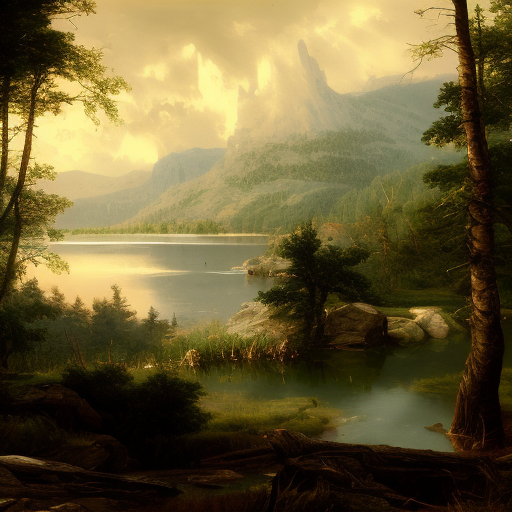

INFO:pytorch_lightning.utilities.seed:Global seed set to 3125493371


Prompt 2 of 2
a beautiful portrait of a woman by Artgerm, trending on Artstation
Batch 1 of 1


  0%|          | 0/80 [00:00<?, ?it/s]

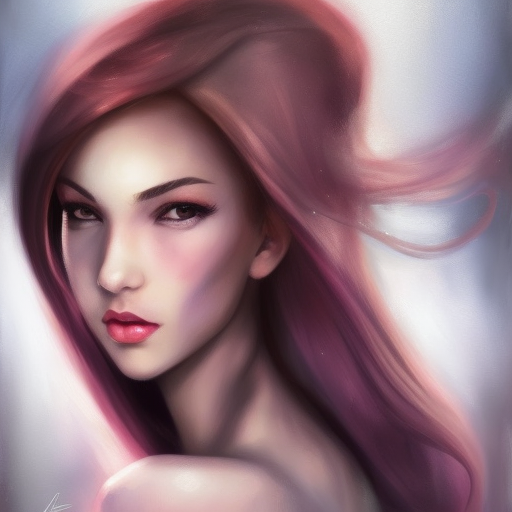

In [7]:
#@markdown **Load Settings**
override_settings_with_file = False #@param {type:"boolean"}
settings_file = "custom" #@param ["custom", "512x512_aesthetic_0.json","512x512_aesthetic_1.json","512x512_colormatch_0.json","512x512_colormatch_1.json","512x512_colormatch_2.json","512x512_colormatch_3.json"]
custom_settings_file = "/content/drive/MyDrive/Settings.txt"#@param {type:"string"}

def DeforumArgs():
    #@markdown **Image Settings**
    W = 512 #@param
    H = 512 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64

    #@markdown **Sampling Settings**
    seed = -1 #@param
    sampler = 'euler_ancestral' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim", "dpm_fast", "dpm_adaptive", "dpmpp_2s_a", "dpmpp_2m"]
    steps = 80 #@param
    scale = 7 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None   

    #@markdown **Save & Display Settings**
    save_samples = True #@param {type:"boolean"}
    save_settings = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}
    save_sample_per_step = False #@param {type:"boolean"}
    show_sample_per_step = False #@param {type:"boolean"}

    #@markdown **Prompt Settings**
    prompt_weighting = True #@param {type:"boolean"}
    normalize_prompt_weights = True #@param {type:"boolean"}
    log_weighted_subprompts = False #@param {type:"boolean"}

    #@markdown **Batch Settings**
    n_batch = 1 #@param
    batch_name = "StableFun" #@param {type:"string"}
    filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
    seed_behavior = "iter" #@param ["iter","fixed","random"]
    make_grid = False #@param {type:"boolean"}
    grid_rows = 2 #@param 
    outdir = get_output_folder(root.output_path, batch_name)

    #@markdown **Init Settings**
    use_init = False #@param {type:"boolean"}
    strength = 0.0 #@param {type:"number"}
    strength_0_no_init = True # Set the strength to 0 automatically when no init image is used
    init_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    # Whiter areas of the mask are areas that change more
    use_mask = False #@param {type:"boolean"}
    use_alpha_as_mask = False # use the alpha channel of the init image as the mask
    mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg" #@param {type:"string"}
    invert_mask = False #@param {type:"boolean"}
    # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
    mask_brightness_adjust = 1.0  #@param {type:"number"}
    mask_contrast_adjust = 1.0  #@param {type:"number"}
    # Overlay the masked image at the end of the generation so it does not get degraded by encoding and decoding
    overlay_mask = True  # {type:"boolean"}
    # Blur edges of final overlay mask, if used. Minimum = 0 (no blur)
    mask_overlay_blur = 5 # {type:"number"}

    #@markdown **Exposure/Contrast Conditional Settings**
    mean_scale = 0 #@param {type:"number"}
    var_scale = 0 #@param {type:"number"}
    exposure_scale = 0 #@param {type:"number"}
    exposure_target = 0.5 #@param {type:"number"}

    #@markdown **Color Match Conditional Settings**
    colormatch_scale = 0 #@param {type:"number"}
    colormatch_image = "https://www.saasdesign.io/wp-content/uploads/2021/02/palette-3-min-980x588.png" #@param {type:"string"}
    colormatch_n_colors = 4 #@param {type:"number"}
    ignore_sat_weight = 0 #@param {type:"number"}

    #@markdown **CLIP\Aesthetics Conditional Settings**
    clip_name = 'ViT-L/14' #@param ['ViT-L/14', 'ViT-L/14@336px', 'ViT-B/16', 'ViT-B/32']
    clip_scale = 0 #@param {type:"number"}
    aesthetics_scale = 0 #@param {type:"number"}
    cutn = 1 #@param {type:"number"}
    cut_pow = 0.0001 #@param {type:"number"}

    #@markdown **Other Conditional Settings**
    init_mse_scale = 0 #@param {type:"number"}
    init_mse_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}

    blue_scale = 0 #@param {type:"number"}
    
    #@markdown **Conditional Gradient Settings**
    gradient_wrt = 'x0_pred' #@param ["x", "x0_pred"]
    gradient_add_to = 'both' #@param ["cond", "uncond", "both"]
    decode_method = 'linear' #@param ["autoencoder","linear"]
    grad_threshold_type = 'dynamic' #@param ["dynamic", "static", "mean", "schedule"]
    clamp_grad_threshold = 0.2 #@param {type:"number"}
    clamp_start = 0.2 #@param
    clamp_stop = 0.01 #@param
    grad_inject_timing = list(range(1,10)) #@param

    #@markdown **Speed vs VRAM Settings**
    cond_uncond_sync = True #@param {type:"boolean"}

    n_samples = 1 # doesnt do anything
    precision = 'autocast' 
    C = 4
    f = 8

    prompt = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_sample_raw = None
    mask_sample = None
    init_c = None

    return locals()

args_dict = DeforumArgs()
anim_args_dict = DeforumAnimArgs()

if override_settings_with_file:
    load_args(args_dict, anim_args_dict, settings_file, custom_settings_file, verbose=False)

args = SimpleNamespace(**args_dict)
anim_args = SimpleNamespace(**anim_args_dict)

args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

# Load clip model if using clip guidance
if (args.clip_scale > 0) or (args.aesthetics_scale > 0):
    root.clip_model = clip.load(args.clip_name, jit=False)[0].eval().requires_grad_(False).to(root.device)
    if (args.aesthetics_scale > 0):
        root.aesthetics_model = load_aesthetics_model(args, root)

if args.seed == -1:
    args.seed = random.randint(0, 2**32 - 1)
if not args.use_init:
    args.init_image = None
if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1
elif anim_args.animation_mode == 'Video Input':
    args.use_init = True

# clean up unused memory
gc.collect()
torch.cuda.empty_cache()

# dispatch to appropriate renderer
if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
    render_animation(args, anim_args, animation_prompts, root)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(args, anim_args, animation_prompts, root)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(args, anim_args, animation_prompts, root)
else:
    render_image_batch(args, prompts, root)

# Create Video From Frames

In [ ]:
skip_video_for_run_all = True #@param {type: 'boolean'}
fps = 12 #@param {type:"number"}
#@markdown **Manual Settings**
use_manual_settings = False #@param {type:"boolean"}
image_path = "/content/drive/MyDrive/AI/StableDiffusion/2022-09/20220903000939_%05d.png" #@param {type:"string"}
mp4_path = "/content/drive/MyDrive/AI/StableDiffusion/2022-09/20220903000939.mp4" #@param {type:"string"}
render_steps = False  #@param {type: 'boolean'}
path_name_modifier = "x0_pred" #@param ["x0_pred","x"]
make_gif = False

if skip_video_for_run_all == True:
    print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')
else:
    import os
    import subprocess
    from base64 import b64encode

    print(f"{image_path} -> {mp4_path}")

    if use_manual_settings:
        max_frames = "200" #@param {type:"string"}
    else:
        if render_steps: # render steps from a single image
            fname = f"{path_name_modifier}_%05d.png"
            all_step_dirs = [os.path.join(args.outdir, d) for d in os.listdir(args.outdir) if os.path.isdir(os.path.join(args.outdir,d))]
            newest_dir = max(all_step_dirs, key=os.path.getmtime)
            image_path = os.path.join(newest_dir, fname)
            print(f"Reading images from {image_path}")
            mp4_path = os.path.join(newest_dir, f"{args.timestring}_{path_name_modifier}.mp4")
            max_frames = str(args.steps)
        else: # render images for a video
            image_path = os.path.join(args.outdir, f"{args.timestring}_%05d.png")
            mp4_path = os.path.join(args.outdir, f"{args.timestring}.mp4")
            max_frames = str(anim_args.max_frames)

    # make video
    cmd = [
        'ffmpeg',
        '-y',
        '-vcodec', 'png',
        '-r', str(fps),
        '-start_number', str(0),
        '-i', image_path,
        '-frames:v', max_frames,
        '-c:v', 'libx264',
        '-vf',
        f'fps={fps}',
        '-pix_fmt', 'yuv420p',
        '-crf', '17',
        '-preset', 'veryfast',
        '-pattern_type', 'sequence',
        mp4_path
    ]
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        print(stderr)
        raise RuntimeError(stderr)

    mp4 = open(mp4_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display.display(display.HTML(f'<video controls loop><source src="{data_url}" type="video/mp4"></video>') )
    
    if make_gif:
         gif_path = os.path.splitext(mp4_path)[0]+'.gif'
         cmd_gif = [
             'ffmpeg',
             '-y',
             '-i', mp4_path,
             '-r', str(fps),
             gif_path
         ]
         process_gif = subprocess.Popen(cmd_gif, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

In [ ]:
skip_disconnect_for_run_all = True #@param {type: 'boolean'}

if skip_disconnect_for_run_all == True:
    print('Skipping disconnect, uncheck skip_disconnect_for_run_all if you want to run it')
else:
    from google.colab import runtime
    runtime.unassign()